# Fit a Huggingface Estimator to distillbert model with emotions dataset

## This is separation and cleanup from working notebook `ssNlpWtch2`

In [4]:
!pip install "sagemaker>=2.48.0" "transformers==4.6.1" "datasets[s3]==1.6.2" --upgrade

  Using cached sagemaker-2.77.1.tar.gz (513 kB)
  Preparing metadata (setup.py) ... done
  Using cached attrs-20.3.0-py2.py3-none-any.whl (49 kB)
  Using cached sagemaker-2.77.0.tar.gz (513 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.76.0.tar.gz (512 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.75.1.tar.gz (511 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.75.0.tar.gz (511 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.74.0.tar.gz (481 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.73.0.tar.gz (481 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.72.3.tar.gz (475 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.72.2.tar.gz (473 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.72.1.tar.gz (473 kB)
  Preparing metadata (setup.py) ... done
  Using cached sagemaker-2.72.0.tar.gz (477 kB)
  Pre

In [5]:
%%capture
import IPython
import sys
!{sys.executable} -m pip install ipywidgets


In [6]:
IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used"

{'status': 'ok', 'restart': True}

In [ ]:
import sagemaker.huggingface

In [2]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::647333706880:role/service-role/AmazonSageMaker-ExecutionRole-20210125T093214
sagemaker bucket: sagemaker-us-east-1-647333706880
sagemaker session region: us-east-1


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
#dataset_name = 'imdb'
dataset_name = 'emotion'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/emotion'

In [4]:
#ss 2022-02-28 once this is loaded and we save to S3
#via cell below, we can just load from s3, no?

# load dataset 
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, validation_dataset,test_dataset = load_dataset(dataset_name, split=['train', 'validation','test'])
test_dataset = test_dataset.shuffle().select(range(2000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
validation_dataset = validation_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset = validation_dataset.rename_column("label", "labels")
validation_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681)
Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681)


In [7]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

# save validation to s3
validation_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/validation'
validation_dataset.save_to_disk(test_input_path,fs=s3)

In [56]:
[sess.default_bucket(),s3_prefix]

['sagemaker-us-east-1-647333706880', 'samples/datasets/emotion']

In [8]:
[training_input_path,test_input_path,validation_input_path]

['s3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/train',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/test',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/validation']

## Creating an Estimator and start a training job

In [9]:
# ss add metrics from ch06
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 3,
             'train_batch_size': 32,
            'checkpoints': '/opt/ml/checkpoints/',
             'model_name':'distilbert-base-uncased'
             }

In [10]:
#h metric def https://bit.ly/3K7qVV7
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [64]:
huggingface_estimator = HuggingFace(entry_point='train_multiclass.py',
                        source_dir='./scripts',
                        instance_type='ml.p3.2xlarge',
                        instance_count=1,
                        role=role,
                        transformers_version='4.6',
                        pytorch_version='1.7',
                        py_version='py36',
                        hyperparameters = hyperparameters,
                        metric_definitions=metric_definitions)

In [12]:
[training_input_path, test_input_path]

['s3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/train',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/test']

In [13]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

2022-02-28 18:47:42 Starting - Starting the training job...
2022-02-28 18:48:10 Starting - Preparing the instances for trainingProfilerReport-1646074062: InProgress
.........
2022-02-28 18:49:42 Downloading - Downloading input data
2022-02-28 18:49:42 Training - Downloading the training image.....................
2022-02-28 18:53:14 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-28 18:53:18,293 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-28 18:53:18,319 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-28 18:53:18,328 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-28 18:53:18,794 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_inp

# estimator finished -- look at some metrics

In [14]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=huggingface_estimator.latest_training_job.name).dataframe()
df.head(90)

,timestamp,metric_name,value
0,0.0,loss,0.779600
1,300.0,loss,0.170900
2,600.0,loss,0.094000
3,0.0,learning_rate,0.000050
4,300.0,learning_rate,2.500000
5,600.0,learning_rate,0.000000
6,0.0,eval_loss,0.222111
7,300.0,eval_loss,0.148584
8,600.0,eval_loss,0.134666
9,0.0,eval_accuracy,0.924000


{'loss': 0.7796, 'learning_rate': 5e-05, 'epoch': 1.0}
{'eval_loss': 0.22211074829101562, 'eval_accuracy': 0.924, 'eval_f1': 0.9242041605829059, 'eval_precision': 0.9246004852140915, 'eval_recall': 0.924, 'eval_runtime': 10.0204, 'eval_samples_per_second': 199.593, 'epoch': 1.0}

In [15]:
!pip install seaborn

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15,5]

<AxesSubplot:label='395b0b39-0a5b-4d4a-816c-18194db4d79b', xlabel='timestamp', ylabel='value'>

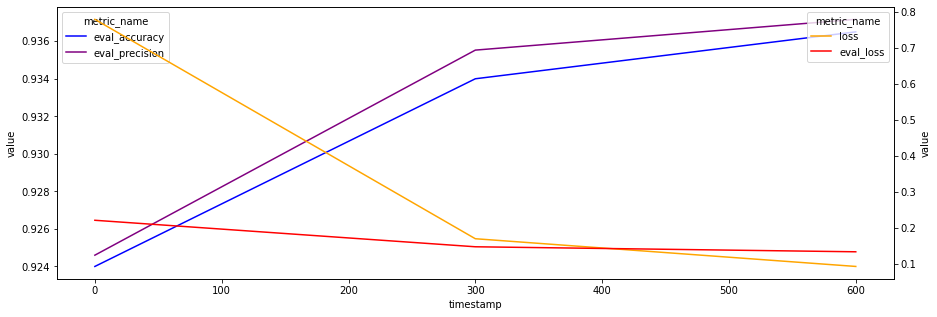

In [17]:
# accuracy: (TP + TN) / (TP + TN + FP + FN)
# precision: TP / (TP + FP)
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    hue='metric_name', 
    palette=['blue', 'purple'])

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name', 
    palette=['orange', 'red'],
    ax=ax2)

### get the output path for the predictor model

In [37]:
from pathlib import PurePath

In [54]:
model_loc = str(PurePath(p).parents[0]/'output/model.tar.gz')
model_loc

's3:/sagemaker-us-east-1-647333706880/huggingface-pytorch-training-2022-02-28-18-47-41-609/output/model.tar.gz'

In [30]:
huggingface_estimator.logs()

2022-02-28 19:13:43 Starting - Preparing the instances for training
2022-02-28 19:13:43 Downloading - Downloading input data
2022-02-28 19:13:43 Training - Training image download completed. Training in progress.
2022-02-28 19:13:43 Uploading - Uploading generated training model
2022-02-28 19:13:43 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-28 18:53:18,293 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-28 18:53:18,319 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-28 18:53:18,328 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-28 18:53:18,794 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train

In [62]:
# wlll need these to regrab the data later
[training_input_path, test_input_path,validation_input_path]

['s3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/train',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/test',
 's3://sagemaker-us-east-1-647333706880/samples/datasets/emotion/validation']

# test